In [208]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

In [209]:
# Mount and define data dir
from google.colab import drive
drive.mount('/content/drive')
datadir = "/content/"
save_dir = "/content/drive/My Drive/CS511/" # change to your directory

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Note: We have subtracted 1.12 seconds from kafdrop timestamps because that is the lag from kafka to kafdrop. We didnt find any api to get count of messages directly from kafka, so we got that count from kafdrop.

Pinot

In [216]:

# Load the CSV files
df_kafdrop_pinot = pd.read_csv(save_dir + 'kafka_pinot_ingestion_result.csv', names=['topic_timestamp', 'asset_topic_count',  'asset_risk_topic_count', 'liabilities_topic_count',  'transactions_topic_count'])
df_pinot = pd.read_csv(save_dir + 'pinot_ingestion_values.csv')
df_kafdrop_pinot['topic_timestamp'] = df_kafdrop_pinot['topic_timestamp']-(1.12*(10**9))

# Remove null values
df_kafdrop_pinot = df_kafdrop_pinot.dropna()
df_pinot = df_pinot.dropna()

# Get average count
df_kafdrop_pinot['avg_topic_count'] = df_kafdrop_pinot[['asset_topic_count',  'asset_risk_topic_count', 'liabilities_topic_count',  'transactions_topic_count']].mean(axis=1)
df_pinot['avg_count'] = df_pinot[['asset_count',  'asset_risk_count', 'liabilities_count',  'transactions_count']].mean(axis=1)

# Remove zero values
df_kafdrop_pinot = df_kafdrop_pinot[df_kafdrop_pinot['avg_topic_count'] != 0.0]
df_pinot = df_pinot[df_pinot['avg_count'] != 0.0]

# Set the timestamps as index for easier merging
df_kafdrop_pinot.set_index('avg_topic_count', inplace=True)
df_pinot.set_index('avg_count', inplace=True)

# Perform an asof merge, which merges on the nearest key rather than requiring an exact match
pinot_merged_data = pd.merge_asof(df_kafdrop_pinot.sort_index(), df_pinot.sort_index(), left_index=True, right_index=True, direction='nearest')

# Reset index to make 'timestamp' a column again and drop rows with NaN values
pinot_merged_data.reset_index(inplace=True)
pinot_cleaned_data = pinot_merged_data.drop_duplicates(subset='avg_topic_count', keep='first').dropna()
pinot_cleaned_data.head()
# Calculate RMSE
pinot_rmse = np.sqrt(mean_squared_error(pinot_cleaned_data['topic_timestamp'], pinot_cleaned_data['timestamp']))

print(pinot_rmse/pow(10,9))


23.338666585373687


Text(0.5, 1.0, 'Pinot Ingestion')

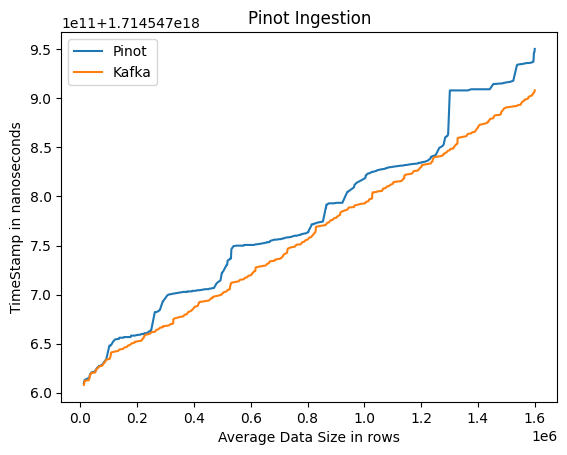

In [232]:
plt.plot(pinot_cleaned_data['avg_topic_count'], pinot_cleaned_data['timestamp'], label='Pinot')
plt.plot(pinot_cleaned_data['avg_topic_count'], pinot_cleaned_data['topic_timestamp'], label='Kafka')
plt.legend()
plt.xlabel('Average Data Size in rows')
plt.ylabel('TimeStamp in nanoseconds')
plt.title('Pinot Ingestion')

Druid

In [221]:
# Load the CSV files
df_kafdrop_druid = pd.read_csv(save_dir + 'kafka_druid_ingestion_result.csv', names=['topic_timestamp', 'asset_topic_count',  'asset_risk_topic_count', 'liabilities_topic_count',  'transactions_topic_count'])
df_druid = pd.read_csv(save_dir + 'druid_ingestion_values.csv')
df_kafdrop_druid['topic_timestamp'] = df_kafdrop_druid['topic_timestamp']-(1.12*(10**9))
# Remove null values
df_kafdrop_druid = df_kafdrop_druid.dropna()
df_druid = df_druid.dropna()

# Get average count
df_kafdrop_druid['avg_topic_count'] = df_kafdrop_druid[['asset_topic_count',  'asset_risk_topic_count', 'liabilities_topic_count',  'transactions_topic_count']].mean(axis=1)
df_druid['avg_count'] = df_druid[['asset_count',  'asset_risk_count', 'liabilities_count',  'transactions_count']].mean(axis=1)

# Remove zero values
df_kafdrop_druid = df_kafdrop_druid[df_kafdrop_druid['avg_topic_count'] != 0.0]
df_druid = df_druid[df_druid['avg_count'] != 0.0]

# Set the timestamps as index for easier merging
df_kafdrop_druid.set_index('avg_topic_count', inplace=True)
df_druid.set_index('avg_count', inplace=True)

# Perform an asof merge, which merges on the nearest key rather than requiring an exact match
druid_merged_data = pd.merge_asof(df_kafdrop_druid.sort_index(), df_druid.sort_index(), left_index=True, right_index=True, direction='nearest')

# Reset index to make 'timestamp' a column again and drop rows with NaN values
druid_merged_data.reset_index(inplace=True)
druid_cleaned_data = druid_merged_data.drop_duplicates(subset='avg_topic_count', keep='first').dropna()
druid_cleaned_data.head()
# Calculate RMSE
druid_rmse = np.sqrt(mean_squared_error(druid_cleaned_data['topic_timestamp'], druid_cleaned_data['timestamp']))

print(druid_rmse/pow(10,9))

1.2691521707277325


Text(0.5, 1.0, 'Druid Ingestion')

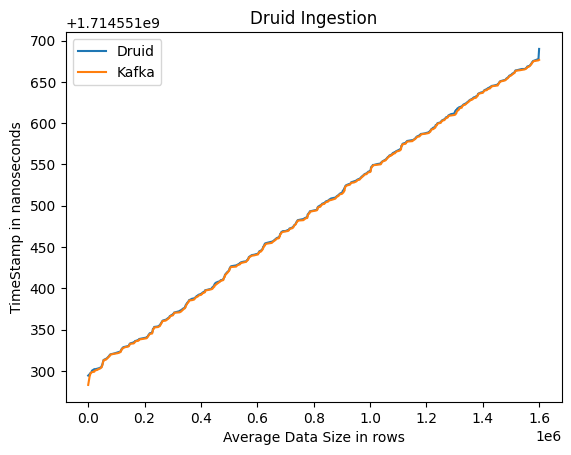

In [233]:
plt.plot(druid_cleaned_data['avg_topic_count'], druid_cleaned_data['timestamp']/pow(10,9), label='Druid')
plt.plot(druid_cleaned_data['avg_topic_count'], druid_cleaned_data['topic_timestamp']/pow(10,9), label='Kafka')
plt.legend()
plt.xlabel('Average Data Size in rows')
plt.ylabel('TimeStamp in nanoseconds')
plt.title('Druid Ingestion')

Clickhouse

In [225]:

# Load the CSV files
df_kafdrop_clickhouse = pd.read_csv(save_dir + 'kafka_clickhouse_ingestion_result.csv', names=['topic_timestamp', 'asset_topic_count',  'asset_risk_topic_count', 'liabilities_topic_count',  'transactions_topic_count'])
df_clickhouse = pd.read_csv(save_dir + 'clickhouse_ingestion_values.csv')

df_kafdrop_clickhouse = df_kafdrop_clickhouse.drop(index=0).reset_index()
df_kafdrop_clickhouse['topic_timestamp'] = df_kafdrop_clickhouse['topic_timestamp']-(1.12*(10**9))

# Remove null values
df_kafdrop_clickhouse = df_kafdrop_clickhouse.dropna()
df_clickhouse = df_clickhouse.dropna()

# Get average count
df_kafdrop_clickhouse['avg_topic_count'] = df_kafdrop_clickhouse[['asset_topic_count',  'asset_risk_topic_count', 'liabilities_topic_count',  'transactions_topic_count']].mean(axis=1)
df_clickhouse['avg_count'] = df_clickhouse[['asset_count',  'asset_risk_count', 'liabilities_count',  'transactions_count']].mean(axis=1)

# Remove zero values
df_kafdrop_clickhouse = df_kafdrop_clickhouse[df_kafdrop_clickhouse['avg_topic_count'] != 0.0]
df_clickhouse = df_clickhouse[df_clickhouse['avg_count'] != 0.0]

# Set the timestamps as index for easier merging
df_kafdrop_clickhouse.set_index('avg_topic_count', inplace=True)
df_clickhouse.set_index('avg_count', inplace=True)

# Perform an asof merge, which merges on the nearest key rather than requiring an exact match
clickhouse_merged_data = pd.merge_asof(df_kafdrop_clickhouse.sort_index(), df_clickhouse.sort_index(), left_index=True, right_index=True, direction='nearest')

# Reset index to make 'timestamp' a column again and drop rows with NaN values
clickhouse_merged_data.reset_index(inplace=True)
clickhouse_cleaned_data = clickhouse_merged_data.drop_duplicates(subset='avg_topic_count', keep='first').dropna()
# Calculate RMSE
clickhouse_rmse = np.sqrt(mean_squared_error(clickhouse_cleaned_data['topic_timestamp'], clickhouse_cleaned_data['timestamp']))

print(clickhouse_rmse/pow(10,9))


3.182492756777569


Text(0.5, 1.0, 'Clickhouse Ingestion')

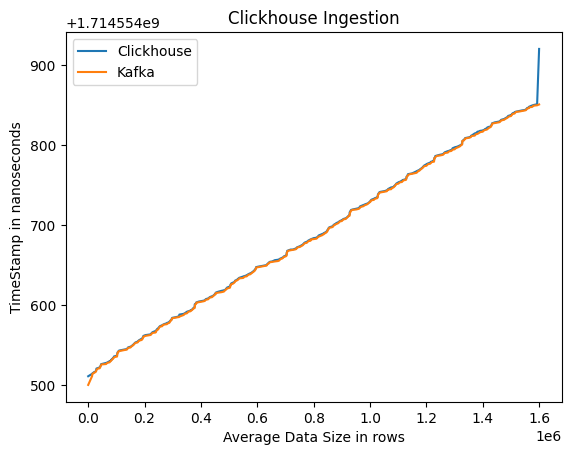

In [234]:
plt.plot(clickhouse_cleaned_data['avg_topic_count'], clickhouse_cleaned_data['timestamp']/pow(10,9), label='Clickhouse')
plt.plot(clickhouse_cleaned_data['avg_topic_count'], clickhouse_cleaned_data['topic_timestamp']/pow(10,9), label='Kafka')
plt.legend()
plt.xlabel('Average Data Size in rows')
plt.ylabel('TimeStamp in nanoseconds')
plt.title('Clickhouse Ingestion')

Starrocks

In [228]:

# Load the CSV files
df_kafdrop_starrocks = pd.read_csv(save_dir + 'kafka_starrocks_ingestion_result.csv', names=['topic_timestamp', 'asset_topic_count',  'asset_risk_topic_count', 'liabilities_topic_count',  'transactions_topic_count'])
df_starrocks = pd.read_csv(save_dir + 'starrocks_ingestion_values.csv')
df_kafdrop_starrocks['topic_timestamp'] = df_kafdrop_starrocks['topic_timestamp']-(1.12*(10**9))
# Remove null values
df_kafdrop_starrocks = df_kafdrop_starrocks.dropna()
df_starrocks = df_starrocks.dropna()

# Get average count
df_kafdrop_starrocks['avg_topic_count'] = df_kafdrop_starrocks[['asset_topic_count',  'asset_risk_topic_count', 'liabilities_topic_count',  'transactions_topic_count']].mean(axis=1)
df_starrocks['avg_count'] = df_starrocks[['asset_count',  'asset_risk_count', 'liabilities_count',  'transactions_count']].mean(axis=1)

# Remove zero values
df_kafdrop_starrocks = df_kafdrop_starrocks[df_kafdrop_starrocks['avg_topic_count'] != 0.0]
df_starrocks = df_starrocks[df_starrocks['avg_count'] != 0.0]

# Set the timestamps as index for easier merging
df_kafdrop_starrocks.set_index('avg_topic_count', inplace=True)
df_starrocks.set_index('avg_count', inplace=True)

# Perform an asof merge, which merges on the nearest key rather than requiring an exact match
starrocks_merged_data = pd.merge_asof(df_kafdrop_starrocks.sort_index(), df_starrocks.sort_index(), left_index=True, right_index=True, direction='nearest')

# Reset index to make 'timestamp' a column again and drop rows with NaN values
starrocks_merged_data.reset_index(inplace=True)
starrocks_cleaned_data = starrocks_merged_data.drop_duplicates(subset='avg_topic_count', keep='first').dropna()
starrocks_cleaned_data.head()
# Calculate RMSE
starrocks_rmse = np.sqrt(mean_squared_error(starrocks_cleaned_data['topic_timestamp'], starrocks_cleaned_data['timestamp']))

print(starrocks_rmse/pow(10,9))



9.915879503443755


Text(0.5, 1.0, 'StarRocks Ingestion')

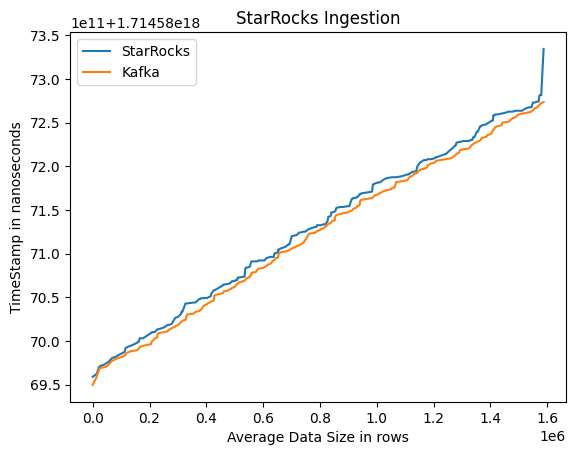

In [238]:
plt.plot(starrocks_cleaned_data['avg_topic_count'], starrocks_cleaned_data['timestamp'], label='StarRocks')
plt.plot(starrocks_cleaned_data['avg_topic_count'], starrocks_cleaned_data['topic_timestamp'],  label='Kafka')
plt.legend()
plt.xlabel('Average Data Size in rows')
plt.ylabel('TimeStamp in nanoseconds')
plt.title('StarRocks Ingestion')